In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
%matplotlib inline  

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
import os
img_dir = 'small_correct-images/'
import matplotlib.image as mpimg

In [4]:
thesis_embeddings = pd.read_csv('thesis_face_embeddings/guess_who_embeddings_pandas.csv')

emb = thesis_embeddings.encodings

emb = (emb
 .str.replace('\n','')
 .str.replace('\r','')
 .str.replace('[','')
 .str.replace(']','')
 .str.split())

emb_lists = emb.tolist()

thesis_emb = np.asarray(emb_lists)

thesis_emb = thesis_emb.astype(np.float)

In [5]:
X_test = thesis_emb 

In [6]:
df = pd.read_csv('csv/thesis_faces_ground_truth.csv')

In [9]:
df.columns

Index(['Unnamed: 0', 'faceID', 'face_perceived_physical-description',
       'face_perceived_ethnicity', 'face_perceived_ethnicity-details',
       'face_perceived_eye', 'face_perceived_hair',
       'face_perceived_photo-gender', 'uniqueID', 'face_gender_mode',
       'face_gender_consensus', 'glasses_mentioned', 'glasses',
       'eye_consensus_prop', 'eye_perceived', 'nr_eye_col',
       'hair_consensus_prop', 'hair_perceived', 'nr_hair_col'],
      dtype='object')

In [7]:
eyes_df = df[['faceID', 'eye_perceived', 'eye_consensus_prop']].sort_values('faceID').reset_index().drop(columns='index')
eyes_df['eye'] = np.where(eyes_df['eye_perceived']=='brown', 0, 1)

In [66]:
eyes_df.eye_perceived

0        tie
1       blue
2      brown
3      brown
4      brown
5      brown
6      brown
7      brown
8      brown
9      brown
10     brown
11      blue
12     brown
13      blue
14     brown
15     brown
16     brown
17     brown
18     brown
19     brown
20     brown
21     brown
22     brown
23     brown
24     brown
25     brown
26     brown
27     brown
28     brown
29     brown
       ...  
163    brown
164    brown
165    brown
166    brown
167    brown
168    brown
169    brown
170    brown
171     blue
172    brown
173    brown
174    brown
175    brown
176    brown
177    brown
178    brown
179    brown
180    brown
181    brown
182    brown
183    brown
184     blue
185     blue
186    brown
187    brown
188    brown
189    brown
190    brown
191    brown
192    brown
Name: eye_perceived, Length: 193, dtype: object

In [8]:
eyes_keras_model = pickle.load(open('lfwa+/eye_keras_model_new.sav', 'rb'))

C:\Users\Paradigit\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
y_prob = eyes_keras_model.predict(X_test)
y_pred = (y_prob > 0.5)

In [10]:
eyes_df['pred_blue_eyes'] = y_pred
eyes_df['pred_prob_blue_eyes'] = y_prob

In [11]:
eyes_df['ethnicity'] = gt.ethnicity

NameError: name 'gt' is not defined

In [12]:
eye_no_tie = eyes_df[eyes_df['eye_perceived'] != 'tie']

eye_tie = eyes_df[eyes_df['eye_perceived'] == 'tie']

In [13]:
eye_no_tie['pred_prob_brown_eyes'] = 1 - eye_no_tie.pred_prob_blue_eyes

C:\Users\Paradigit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
pred_brown = eye_no_tie[eye_no_tie.pred_blue_eyes == 0].sort_values('pred_prob_blue_eyes')
pred_blue = eye_no_tie[eye_no_tie.pred_blue_eyes == 1].sort_values('pred_prob_blue_eyes')

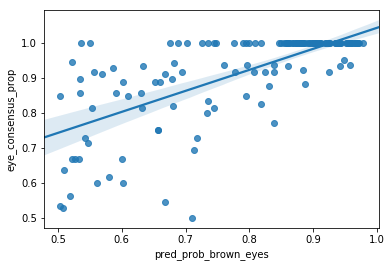

In [15]:
ax = sns.regplot(x="pred_prob_brown_eyes", y="eye_consensus_prop", data=pred_brown)

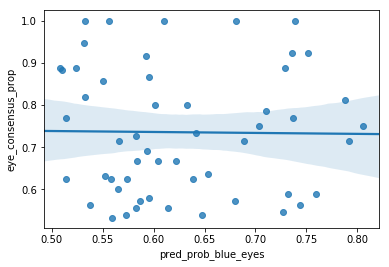

In [102]:
ax = sns.regplot(x="pred_prob_blue_eyes", y="eye_consensus_prop", data=pred_blue)

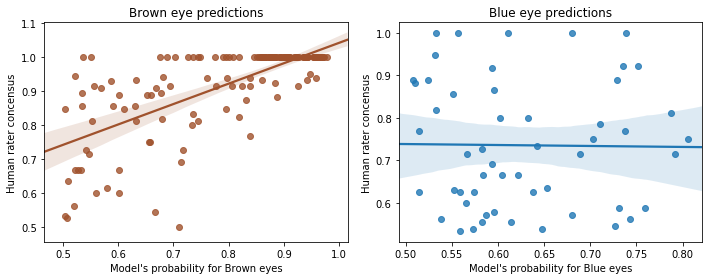

In [57]:
f, (ax1, ax2) = plt.subplots(1,2,  figsize=(10, 4))

sns.regplot(x="pred_prob_brown_eyes", y="eye_consensus_prop", data=pred_brown, ax=ax1,  color = 'sienna').set(ylabel='Human rater concensus', xlabel="Model's probability for Brown eyes",  title='Brown eye predictions')
sns.regplot(x="pred_prob_blue_eyes", y="eye_consensus_prop", data=pred_blue, ax=ax2).set(ylabel='Human rater concensus', xlabel="Model's probability for Blue eyes",  title='Blue eye predictions')

plt.tight_layout()

In [88]:
eye_tie.head(30)

,faceID,eye_perceived,eye_consensus_prop,eye,pred_blue_eyes,pred_prob_blue_eyes
0,IMG_0003,tie,0.5,1,True,0.730184
48,IMG_0761,tie,0.5,1,True,0.530671
56,IMG_7578,tie,0.5,1,False,0.272180
157,IMG_9454,tie,0.5,1,False,0.191462


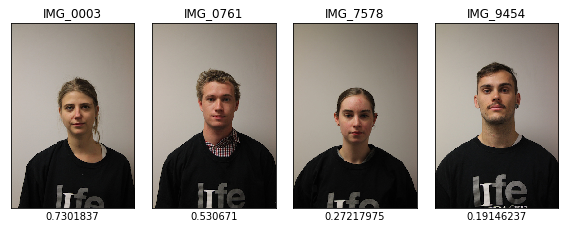

In [105]:
plt.figure(figsize=(8,8))
for i, face in enumerate(eye_tie.faceID):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel(eye_tie.pred_prob_blue_eyes.values[i])

plt.tight_layout()
plt.show()

In [16]:
def confusion(row):
    if row.eye == 1:
        if row.pred_blue_eyes == 1:
            return 'true blue eyes'
        if row.pred_blue_eyes == 0:
            return 'false brown eyes'
    
    if row.eye == 0:
        if row.pred_blue_eyes == 0:
            return 'true brown eyes'
        if row.pred_blue_eyes == 1:
            return 'false blue eyes'

        
eye_no_tie['confusion'] = eye_no_tie.apply(confusion, axis=1)

C:\Users\Paradigit\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
eye_no_tie.head()

,faceID,eye_perceived,eye_consensus_prop,eye,pred_blue_eyes,pred_prob_blue_eyes,pred_prob_brown_eyes,confusion
1,IMG_0018,blue,0.545455,1,False,0.332930,0.667070,false brown eyes
2,IMG_0033,brown,0.916667,0,False,0.223118,0.776882,true brown eyes
3,IMG_0048,brown,0.714286,0,True,0.689052,0.310948,false blue eyes
4,IMG_0063,brown,0.692308,0,False,0.287071,0.712929,true brown eyes
5,IMG_0078,brown,0.812500,0,False,0.446503,0.553497,true brown eyes


In [87]:
eye_no_tie.eye_perceived.value_counts()

brown    173
blue      16
Name: eye_perceived, dtype: int64

In [86]:
eye_no_tie.pred_blue_eyes.value_counts()

False    136
True      53
Name: pred_blue_eyes, dtype: int64

In [73]:
eye_no_tie.confusion.value_counts()

true brown eyes     135
false blue eyes      38
true blue eyes       15
false brown eyes      1
Name: confusion, dtype: int64

In [75]:
y_test = eye_no_tie.eye.values
y_pred = eye_no_tie.pred_blue_eyes.values

In [41]:
eyes_df
y_test = eyes_df.eye.values
y_pred = eyes_df.pred_blue_eyes.values

In [43]:

print("{:.3}".format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

0.794
             precision    recall  f1-score   support

          0       0.99      0.78      0.87       173
          1       0.28      0.94      0.43        16

avg / total       0.93      0.79      0.84       189

[[135  38]
 [  1  15]]


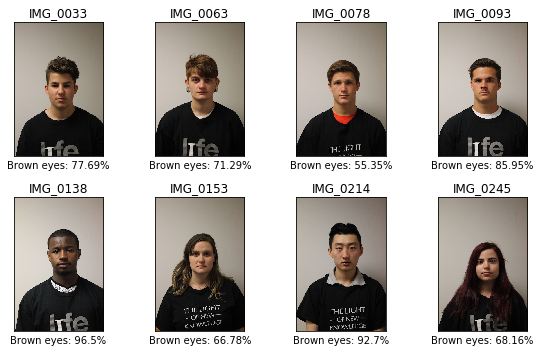

In [25]:
# 8  male classification by both human and model with highest prob scores
brown = eye_no_tie[eye_no_tie.confusion == 'true brown eyes'].sort_values('pred_prob_brown_eyes', ascending=False).faceID.values
brown_prob = eye_no_tie[eye_no_tie.confusion == 'true brown eyes'].sort_values('pred_prob_brown_eyes', ascending=False).pred_prob_brown_eyes.values

plt.figure(figsize=(8,5))
for i, face in enumerate(brown[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel('Brown eyes: ' + str(round(true_males_prob[i] * 100,2)) + '%')

plt.tight_layout()
plt.show()

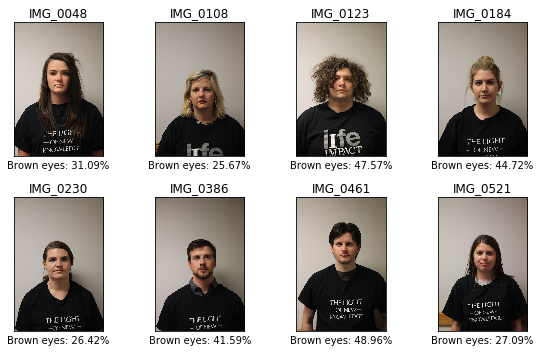

In [23]:
# 8  male classification by both human and model with highest prob scores
fbrown = eye_no_tie[eye_no_tie.confusion == 'false blue eyes'].faceID.values
fbrown_prob = eye_no_tie[eye_no_tie.confusion == 'false blue eyes'].pred_prob_brown_eyes.values

plt.figure(figsize=(8,5))
for i, face in enumerate(fbrown[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel('Brown eyes: ' + str(round(fbrown_prob[i] * 100,2)) + '%')

plt.tight_layout()
plt.show()

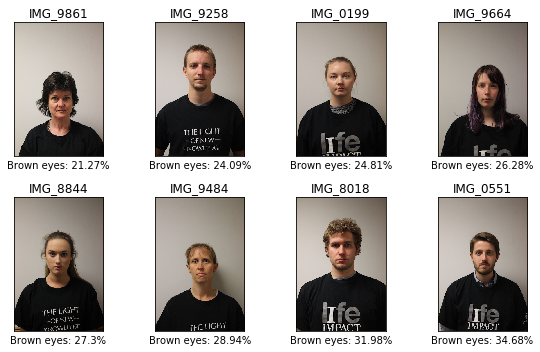

In [26]:
# 8  male classification by both human and model with highest prob scores
fbrown = eye_no_tie[eye_no_tie.confusion == 'true blue eyes'].sort_values('pred_prob_brown_eyes', ascending=True).faceID.values
fbrown_prob = eye_no_tie[eye_no_tie.confusion == 'true blue eyes'].sort_values('pred_prob_brown_eyes', ascending=True).pred_prob_brown_eyes.values

plt.figure(figsize=(8,5))
for i, face in enumerate(fbrown[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel('Brown eyes: ' + str(round(fbrown_prob[i] * 100,2)) + '%')

plt.tight_layout()
plt.show()

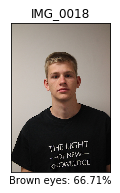

In [21]:
# 8  male classification by both human and model with highest prob scores
fbrown = eye_no_tie[eye_no_tie.confusion == 'false brown eyes'].sort_values('pred_prob_brown_eyes', ascending=False).faceID.values
fbrown_prob = eye_no_tie[eye_no_tie.confusion == 'false brown eyes'].sort_values('pred_prob_brown_eyes', ascending=False).pred_prob_brown_eyes.values

plt.figure(figsize=(8,5))
for i, face in enumerate(fbrown[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel('Brown eyes: ' + str(round(fbrown_prob[i] * 100,2)) + '%')

plt.tight_layout()
plt.show()

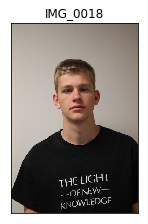

In [34]:
false_brown = eye_no_tie[eye_no_tie.confusion == 'false brown eyes']

plt.figure(figsize=(8,8))
for i, face in enumerate(false_brown.faceID.values):
    
    plt.subplot(1,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel('Glasses: ' + str(round(false_blue.pred_prob_blue_eyes[i] * 100, 2)) + '%')

plt.tight_layout()
plt.show()

In [1]:
true_brown = eye_no_tie[eye_no_tie.confusion == 'true brown eyes']

plt.figure(figsize=(8,8))
for i, face in enumerate(true_brown.faceID.values[:24]):
    
    plt.subplot(4,6,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel('Glasses: ' + str(round(false_blue.pred_prob_blue_eyes[i] * 100, 2)) + '%')

#plt.tight_layout()
plt.show()

NameError: name 'eye_no_tie' is not defined

In [31]:
false_blue.eye_consensus_prop.mean()

0.7548311793352124

In [32]:
false_blue.head()

,faceID,eye_perceived,eye_consensus_prop,eye,pred_blue_eyes,pred_prob_blue_eyes,pred_prob_brown_eyes,confusion
3,IMG_0048,brown,0.714286,0,True,0.689052,0.310948,false blue eyes
7,IMG_0108,brown,0.562500,0,True,0.743288,0.256712,false blue eyes
8,IMG_0123,brown,0.888889,0,True,0.524317,0.475683,false blue eyes
12,IMG_0184,brown,0.631579,0,True,0.552769,0.447231,false blue eyes
15,IMG_0230,brown,0.923077,0,True,0.735762,0.264238,false blue eyes


In [60]:
tbr_m = eye_no_tie[eye_no_tie.confusion == 'true brown eyes']['pred_prob_brown_eyes'].mean()
tbr_std = eye_no_tie[eye_no_tie.confusion == 'true brown eyes']['pred_prob_brown_eyes'].std()

br_m = eye_no_tie[eye_no_tie.pred_blue_eyes == 0]['pred_prob_brown_eyes'].mean()
br_std = eye_no_tie[eye_no_tie.pred_blue_eyes == 0]['pred_prob_brown_eyes'].std()

tbl_m = eye_no_tie[eye_no_tie.confusion == 'true blue eyes']['pred_prob_blue_eyes'].mean()
tbl_std = eye_no_tie[eye_no_tie.confusion == 'true blue eyes']['pred_prob_blue_eyes'].std()

bl_m = eye_no_tie[eye_no_tie.pred_blue_eyes == 1]['pred_prob_blue_eyes'].mean()
bl_std = eye_no_tie[eye_no_tie.pred_blue_eyes == 1]['pred_prob_blue_eyes'].std()

print('True brown Mean Probability:',tbr_m)
print('True brown std Probability:',tbr_std)
print()
print('True blue Mean Probability:',tbl_m)
print('True blue std Probability:',tbl_std)
print()
print('brown Mean Probability:',br_m)
print('brown std Probability:',br_std)
print()
print(' blue Mean Probability:',bl_m)
print('blue std Probability:',bl_std)

True brown Mean Probability: 0.7886611819267273
True brown std Probability: 0.14753055572509766

True blue Mean Probability: 0.6537372469902039
True blue std Probability: 0.08758623898029327

brown Mean Probability: 0.7877671122550964
brown std Probability: 0.1473524421453476

 blue Mean Probability: 0.6272700428962708
blue std Probability: 0.08475705981254578


# ethnicity

In [78]:
eye_no_tie[eye_no_tie.confusion == 'true brown eyes'].ethnicity.value_counts()

white    77
asian    41
other    15
black     2
Name: ethnicity, dtype: int64

In [85]:
high_cons.eye_perceived.value_counts()

brown    145
blue       6
Name: eye_perceived, dtype: int64